In [2]:
import torch 
import torchvision 
import matplotlib.pyplot as plt
import torch.nn as nn 
import torch.nn.functional as F
import numpy as np

In [3]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307, ), (0.3081))
])

#downloading MNIST dataset and checking batch normalization effect in it 
train_set = torchvision.datasets.MNIST(root="../", train=True,transform=transform, download=True)
test_set = torchvision.datasets.MNIST("../", train=False, transform=transform, download=True)
len(train_set), len(test_set)

(60000, 10000)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device 

device(type='cuda')

In [5]:
batch_size_train = 32
batch_size_test = 100

In [6]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size_train, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size_test, shuffle = True)
train_loader, test_loader

(<torch.utils.data.dataloader.DataLoader at 0x2c4b7e477c0>,
 <torch.utils.data.dataloader.DataLoader at 0x2c4b7e478b0>)

C:\Users\OMEN\AppData\Local\Temp\ipykernel_4664\2731431046.py:6: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


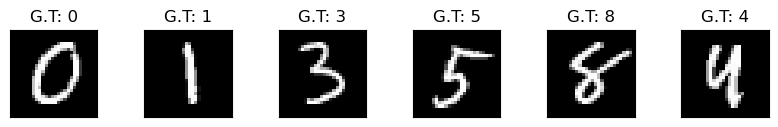

In [7]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
fig = plt.figure(figsize = (8,8))
for i in range(6):
    plt.subplot(1,6,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray',interpolation='none')
    plt.title("G.T: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])

In [8]:
example_data.shape 

torch.Size([100, 1, 28, 28])

In [9]:
16*25

400

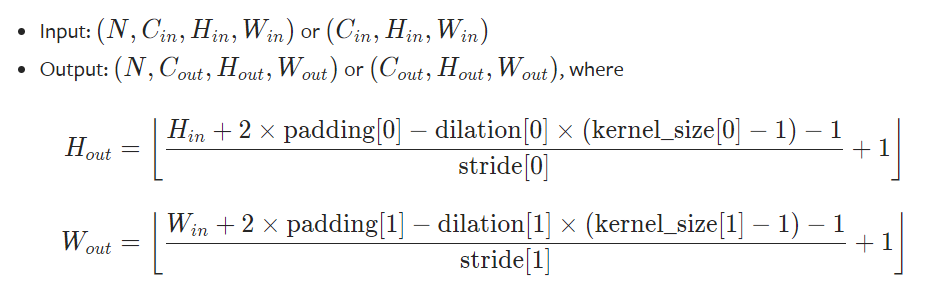

In [10]:
# 16*16
# 2560 - 3 + 1
# 2558//2 +1
# 20*3*3


28-3+1
13-3+1
20*5*5

500

In [11]:
28-5+1
12-5+1
20*4*4

320

In [12]:
#constructing a neural network 
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        #default stride = 1, padding = 0, dilation = 1 ??, 28*28
        # 10 1x3x3
        self.conv1 = nn.Conv2d(in_channels = 1,out_channels = 10, kernel_size =5)
        #gives output 10x24*24
        #with maxpool gives 10x12x12
        
        #20 10x3x3
        self.conv2 = nn.Conv2d(in_channels = 10,out_channels = 20, kernel_size=5)
        # gives output 20x8x8 but with maxpool, gives 20x4x4
        
        self.drop = nn.Dropout2d()
        #output of conv = out_channels * H2*W2
        
        #20x3x3
        self.linear1 = nn.Linear(320, 50)
        self.linear2 = nn.Linear(50, 10)
        
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        print(f'{x.shape} is the shape of x')
        x = F.relu(self.linear1(x))
        x = F.dropout(x, training=self.training)
        x = self.linear2(x)
        return F.log_softmax(x)   

In [13]:
#constructing a neural network 
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        #default stride = 1, padding = 0, dilation = 1 ??, 28*28
        # 10 1x3x3
        self.conv1 = nn.Conv2d(in_channels = 1,out_channels = 10, kernel_size =3)
        #gives output 10x26x26
        #with maxpool gives 10x13x13
        
        #20 10x3x3
        self.conv2 = nn.Conv2d(in_channels = 10,out_channels = 20, kernel_size=3)
        # gives output 20x11x11 but with maxpool, gives 20x5x5
        
        self.drop = nn.Dropout2d()
        #output of conv = out_channels * H2*W2
        
        #20x3x3
        self.linear1 = nn.Linear(500, 50)
        self.linear2 = nn.Linear(50, 10)
        
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.drop(self.conv2(x)), 2))
        x = x.view(-1, 500)
#         print(f'{x.shape} is the shape of x')
        x = F.relu(self.linear1(x))
        x = F.dropout(x, training=self.training)
        x = self.linear2(x)
        return F.log_softmax(x)   

In [14]:
network = Network() 
network

Network(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (drop): Dropout2d(p=0.5, inplace=False)
  (linear1): Linear(in_features=500, out_features=50, bias=True)
  (linear2): Linear(in_features=50, out_features=10, bias=True)
)

In [15]:
network = network.to(device)

In [16]:
def train(model, n_epochs=20):
    # number of epochs to train the model
    n_epochs = n_epochs
    # track losses
    losses = []
        
    # optimization strategy 
    # specify loss function (categorical cross-entropy)
    criterion = nn.CrossEntropyLoss()

    # specify optimizer (stochastic gradient descent) and learning rate = 0.01
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

    # set the model to training mode
    model.train()
    
    for epoch in range(1, n_epochs+1):
        # monitor training loss
        train_loss = 0.0

        ###################
        # train the model #
        ###################
        batch_count = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data.to(device))
            # calculate the loss
            loss = criterion(output, target.to(device))
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update average training loss
            train_loss += loss.item() # add up avg batch loss
            batch_count +=1                

        # print training statistics 
        losses.append(train_loss/batch_count)
        print('Epoch: {} \tTraining Loss: {:.6f}'.format(
            epoch, 
            train_loss/batch_count))
    
    # return all recorded batch losses
    return losses
        

In [17]:
len(test_loader)

100

In [21]:
losses_without_norm = train(network)

C:\Users\OMEN\AppData\Local\Temp\ipykernel_4664\903452471.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Epoch: 1 	Training Loss: 0.506845
Epoch: 2 	Training Loss: 0.375587
Epoch: 3 	Training Loss: 0.318739
Epoch: 4 	Training Loss: 0.274990
Epoch: 5 	Training Loss: 0.254971
Epoch: 6 	Training Loss: 0.235242
Epoch: 7 	Training Loss: 0.224085
Epoch: 8 	Training Loss: 0.213594
Epoch: 9 	Training Loss: 0.202051
Epoch: 10 	Training Loss: 0.195828
Epoch: 11 	Training Loss: 0.196982
Epoch: 12 	Training Loss: 0.185376
Epoch: 13 	Training Loss: 0.182775
Epoch: 14 	Training Loss: 0.180569
Epoch: 15 	Training Loss: 0.174560
Epoch: 16 	Training Loss: 0.171220
Epoch: 17 	Training Loss: 0.169207
Epoch: 18 	Training Loss: 0.170242
Epoch: 19 	Training Loss: 0.163531
Epoch: 20 	Training Loss: 0.164751


In [22]:
torch.save(network.state_dict(), 'trained_model.pth')

In [23]:
NoNormLoss = np.array(losses_without_norm)

In [26]:
def test(model, train):
    # initialize vars to monitor test loss and accuracy
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    test_loss = 0.0
    test_losses = []

    # set model to train or evaluation mode
    # just to see the difference in behavior
    if(train==True):
        model.train()
    if(train==False):
        model.eval()
    
    # loss criterion
    criterion = nn.CrossEntropyLoss()
    
    for batch_idx, (data, target) in enumerate(test_loader):
        batch_size = data.size(0)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data.to(device))
        # calculate the loss
        loss = criterion(output, target.to(device))
        # update average test loss 
        test_loss += loss.item()*batch_size
        
        if batch_idx%10==0:
            test_losses.append(loss.item())
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)
        # compare predictions to true label
        correct = np.squeeze(pred.eq(target.to(device).data.view_as(pred)))
        # calculate test accuracy for each object class
        for i in range(batch_size):
            label = target.to(device).data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

    print('Test Loss: {:.6f}\n'.format(test_loss/len(test_loader.dataset)))

    for i in range(10):
        if class_total[i] > 0:
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
                str(i), 100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]), np.sum(class_total[i])))
        else:
            print('Test Accuracy of %5s: N/A (no training examples)' % (class_correct[i]))

    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
        100. * np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)))
    
    return test_losses

In [27]:
test_loss_train = test(network, train=True)
test_loss_train =  np.array(test_loss_train)
test_loss_eval = test(network, train=False)
test_loss_eval = np.array(test_loss_eval)
test_loss_train, test_loss_eval

C:\Users\OMEN\AppData\Local\Temp\ipykernel_4664\903452471.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Test Loss: 0.150876

Test Accuracy of     0: 98% (962/980)
Test Accuracy of     1: 98% (1115/1135)
Test Accuracy of     2: 93% (964/1032)
Test Accuracy of     3: 95% (963/1010)
Test Accuracy of     4: 96% (949/982)
Test Accuracy of     5: 95% (853/892)
Test Accuracy of     6: 95% (919/958)
Test Accuracy of     7: 95% (981/1028)
Test Accuracy of     8: 92% (901/974)
Test Accuracy of     9: 92% (932/1009)

Test Accuracy (Overall): 95% (9539/10000)
Test Loss: 0.048058

Test Accuracy of     0: 99% (976/980)
Test Accuracy of     1: 99% (1130/1135)
Test Accuracy of     2: 98% (1019/1032)
Test Accuracy of     3: 98% (996/1010)
Test Accuracy of     4: 99% (975/982)
Test Accuracy of     5: 98% (878/892)
Test Accuracy of     6: 98% (942/958)
Test Accuracy of     7: 98% (1011/1028)
Test Accuracy of     8: 97% (952/974)
Test Accuracy of     9: 96% (973/1009)

Test Accuracy (Overall): 98% (9852/10000)


(array([0.15835345, 0.16948529, 0.09496937, 0.07475432, 0.1541457 ,
        0.22875041, 0.14902112, 0.16122602, 0.05515368, 0.18040165]),
 array([0.12081049, 0.0062903 , 0.00992177, 0.04121153, 0.03420517,
        0.00988979, 0.04559647, 0.02112463, 0.01912869, 0.04506225]))

In [28]:
np.save('train_loss_without_bn.npy', NoNormLoss)
np.save('test_loss_train_without_bn.npy', test_loss_train)
np.save('test_loss_eval_without_bn.npy', test_loss_eval)

In [ ]:
test_loss_train.shape, test_loss_eval.shape , NoNormLoss.shape 

((10,), (10,), (10,))

In [ ]:
#train_loss without batchnorm -> NoNormLoss 
#test_loss with train without batch_norm -> test_loss_train 
#test_loss with eval without batch_norm -> test_loss_eval 


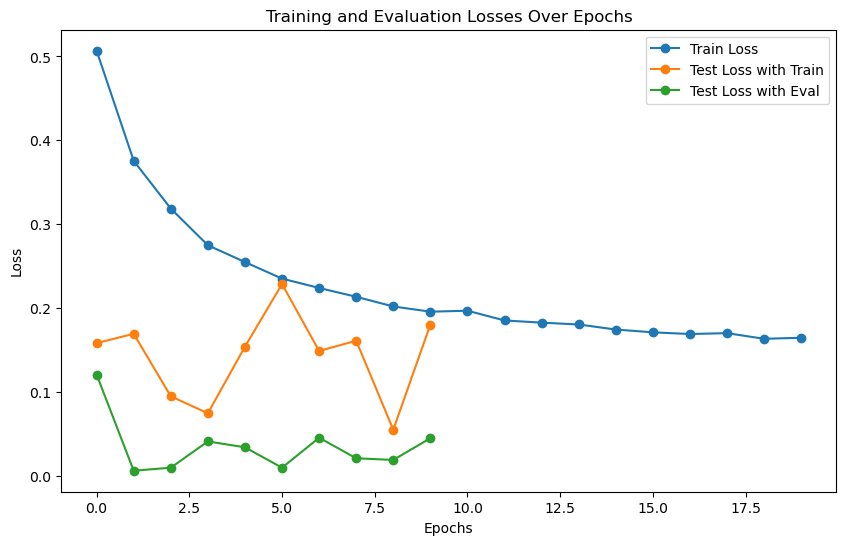

In [29]:
# Plotting the losses
plt.figure(figsize=(10, 6))
plt.plot( NoNormLoss, label='Train Loss', marker='o')
plt.plot(test_loss_train, label='Test Loss with Train', marker='o')
plt.plot( test_loss_eval, label='Test Loss with Eval', marker='o')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Evaluation Losses Over Epochs')
plt.legend()

# Show the plot
plt.show()

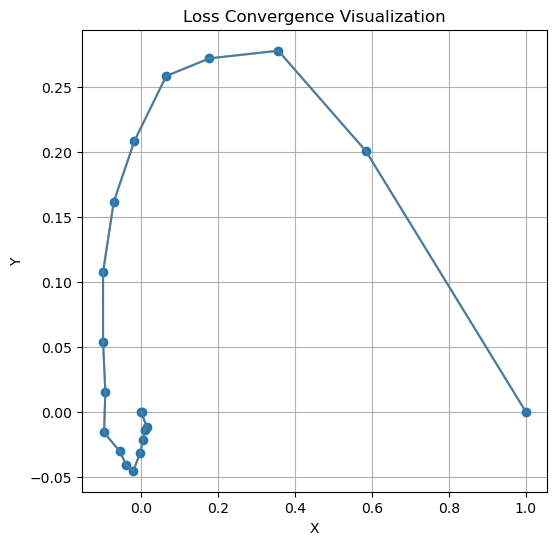

In [30]:
# Normalize the losses to [0, 1]
normalized_losses = (NoNormLoss - NoNormLoss.min()) / (NoNormLoss.max() - NoNormLoss.min())
#visualizing the loss of training 
angles = np.linspace(0, 2 * np.pi, len(normalized_losses))
# Convert angles to x, y coordinates
x = normalized_losses * np.cos(angles)
y = normalized_losses * np.sin(angles)

# Create the plot
plt.figure(figsize=(6, 6))
plt.plot(x, y, marker='o')

# Optionally, connect the points to show progression
for i in range(len(x) - 1):
    plt.plot([x[i], x[i+1]], [y[i], y[i+1]], 'gray', alpha=0.5)

plt.title("Loss Convergence Visualization")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.show()

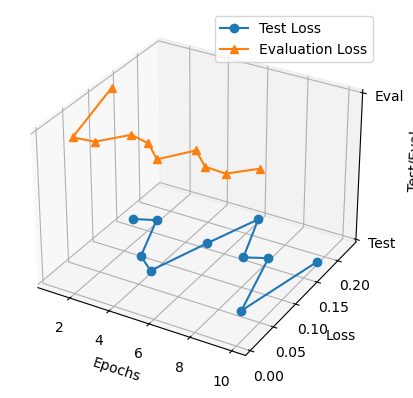

In [31]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Your data
# test_losses = np.array([0.1440209, 0.10971382, 0.21037549, 0.17068653, 0.30142769,
#                         0.19968837, 0.22710213, 0.08960139, 0.2571283, 0.35532638])
# eval_losses = np.array([0.04298709, 0.01465678, 0.04868861, 0.03997676, 0.11347672,
#                         0.04338855, 0.02887211, 0.04900452, 0.06064821, 0.05560763])
epochs = np.arange(1, len(test_loss_train) + 1)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Create a third axis based on a categorical distinction: Test = 0, Eval = 1
test_eval_axis = np.zeros(len(test_loss_train))
eval_eval_axis = np.ones(len(test_loss_eval))

# Plot both sets of losses in 3D
ax.plot(epochs, test_loss_train, test_eval_axis, label='Test Loss', marker='o')
ax.plot(epochs, test_loss_eval, eval_eval_axis, label='Evaluation Loss', marker='^')

ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_zlabel('Test/Eval')
ax.set_zticks([0, 1])
ax.set_zticklabels(['Test', 'Eval'])

plt.legend()
plt.show()

In [20]:
#lets use batch normalization then 


#constructing a neural network 
class Network_BN(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        #default stride = 1, padding = 0, dilation = 1 ??, 28*28
        # 10 1x3x3
        self.conv1 = nn.Conv2d(in_channels = 1,out_channels = 10, kernel_size =3)
        #gives output 10x26x26
        #with maxpool gives 10x13x13
        
        #20 10x3x3
        self.conv2 = nn.Conv2d(in_channels = 10,out_channels = 20, kernel_size=3)
        # gives output 20x11x11 but with maxpool, gives 20x5x5
        
        self.drop = nn.Dropout2d()
        #output of conv = out_channels * H2*W2
        
        #20x3x3
        self.linear1 = nn.Linear(500, 50)
        self.linear2 = nn.Linear(50, 10)
        
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.drop(self.conv2(x)), 2))
        x = x.view(-1, 500)
#         print(f'{x.shape} is the shape of x')
        x = F.relu(self.linear1(x))
        x = F.dropout(x, training=self.training)
        x = self.linear2(x)
        return F.log_softmax(x)   